In [1]:
import pandas as pd
import luxpy as lx # package for color science calculations 
# print('Luxpy version: ',lx.__VERSION__)
# version: v1.9.6
import numpy as np # fundamental package for scientific computing 
import matplotlib.pyplot as plt # package for plotting
import copy
from scipy import interpolate
from luxpy.toolboxes import spdbuild as spb

In [52]:
#ILLUMINANCE AND DATA LOADING
def load_data(filepath, spdData):
    # load data from a txt file and put it into a pandas dataframe
    spdData = pd.read_csv(filepath, sep=' |:', header=None, engine='python')
    spdData.columns = ['Light','Channel','Value']
    spdData['Luminance'] = spdData.apply(lambda x: float(lx.spd_to_power(eval(x['Value']), ptype='pu')), axis=1)
    return spdData

def get_per_channel_luminance(i, channel, luminance):
    # for each channel (RGBA) get each luminance per driver (0-255)
    for j in range(0,256,5):
        channel.append(j)
        luminance.append(spdData['Luminance'][spdData['Light']==i][spdData['Channel']==j])
    return channel, luminance
    
def get_luminance():
    # get interpolated luminance for each channel
    for i in [1,2,3,5]:
        channel = []
        luminance = []
        col = np.where(i==1, 'r', np.where(i==2, 'g', np.where(i==3, 'b', 'y')))
        channel, luminance = get_per_channel_luminance(i, channel, luminance)
        largestLum.append(float(luminance[-1]))    # record the largest luminance of every channel

        x = np.array(channel)
        y = np.array(luminance) 
        interpolation_funcs.append(interpolate.UnivariateSpline(y,x,s=0)) # interpolation: pass all the points
    largestLum.insert(3,None) # To easily process in function of ChannelValue
    interpolation_funcs.insert(3,None)
    return interpolation_funcs

def plot_luminance():
    # plot luminance per channel
    for i in [1,2,3,5]:
        channel = []
        luminance = []
        col = np.where(i==1, 'r', np.where(i==2, 'g', np.where(i==3, 'b', 'y')))
        channel, luminance = get_per_channel_luminance(i, channel, luminance)
        plt.plot(channel,luminance,str(col),label='light:'+str(col))
        plt.legend()
        plt.xlabel('Value')
        plt.ylabel('Luminance[cd/m^2]')
        plt.title('Relation between Value of Channel and Luminance')
        plt.show    #plot

def ChannelValue(l:int, perc:float): 
    # input: l:light(R-1,G-2,B-3,A-5), perc:the percentage of the maximum luminance of the channel
    # output: the channel value(1~251)
    return int(interpolation_funcs[l-1](perc*largestLum[l-1]))   

def get_drivers():
    # get values for driver for each channel per given weight
    digit.append(ChannelValue(1, w[0]))
    digit.append(ChannelValue(2, w[1]))
    digit.append(ChannelValue(3, w[2]))
    digit.append(ChannelValue(5, w[3]))

In [53]:
#3 AND N COLOR MIXING
def get_primaries():
# lx.SPD(np.array(eval(spdData['Value'].iloc[25]))).plot()
# lx.SPD(np.array(eval(spdData['Value'].iloc[51]))).plot()
# lx.SPD(np.array(eval(spdData['Value'].iloc[77]))).plot()
#lx.SPD(np.array(eval(spdData['Value'].iloc[103]))).plot()
    
    # get primary values for color mixing
    r_primary = np.array(copy.copy(eval(spdData['Value'].iloc[51])))
    g_primary = np.array(copy.copy(eval(spdData['Value'].iloc[103])))
    b_primary = np.array(copy.copy(eval(spdData['Value'].iloc[155])))
    a_primary = np.array(copy.copy(eval(spdData['Value'].iloc[207])))
    
    #t_color = lx._CIE_ILLUMINANTS['LED_B1']
    primaries.append(r_primary)
    primaries.append(g_primary)
    primaries.append(b_primary)
    primaries.append(a_primary)
    return

def get_cp():
    # get xyz array of primaries
    xyzr = lx.spd_to_xyz(primaries[0], relative= False ) 
    Yxyr = lx.xyz_to_Yxy(xyzr)
    xyzg = lx.spd_to_xyz(primaries[1], relative= False)
    Yxyg = lx.xyz_to_Yxy(xyzg)
    xyzb = lx.spd_to_xyz(primaries[2], relative= False) 
    Yxyb = lx.xyz_to_Yxy(xyzb)
    xyza = lx.spd_to_xyz(primaries[3], relative=False) 
    Yxya = lx.xyz_to_Yxy(xyza)
    
    return np.array([xyzr[0], xyzg[0], xyzb[0], xyza[0]]).T

def get_target_color_xyz(type_calc,spd = None, cct = None, duv= None, Lum= None):
    # get xyz of target color  # type_calc - defines from what we're calcuclating xyz value(spd, cct...)
    if type_calc == 'cct,duv':
        xyzt_cct_test_scaled = lx.cct_to_xyz(CCT, Duv) #, cieobs = cieobs, cct_offset = None) #relative(scaled)
        xyzt_cct_test = Lum*xyzt_cct_test_scaled #relative to absolute
    else:
        # xyzt = lx.spd_to_xyz(spd, relative= False)
        xyzt = np.array([[51.8347, 42.0302, 78.0537]])
    return xyzt
    
def get_target_color_yxy(type_calc,spd = None, cct = None, duv= None, Lum= None):
    # get Yxy of target color  # type_calc - defines from what we're calcuclating xyz value(spd, cct...)
    if type_calc == 'cct,duv':
        xyzt_cct_test_scaled = lx.cct_to_xyz(CCT, Duv) #, cieobs = cieobs, cct_offset = None) #relative(scaled)
        xyzt_cct_test = Lum*xyzt_cct_test_scaled #relative to absolute
        Yxyt_cct_test = lx.xyz_to_Yxy(xyzt_cct_test)
    else:
        # xyzt = lx.spd_to_xyz(spd, relative= False)
        xyzt = np.array([[51.8347, 42.0302, 78.0537]])
        Yxyt = lx.xyz_to_Yxy(xyzt) 
    return Yxyt

#3-channel color mixing
def three_color_mixing(cp, xyzt):
    cp = cp[:,:3]
    print(cp)
    w = np.linalg.inv(cp) @ xyzt.T
    
    # check if calculated weights are correct
    print(w[0]*cp.T[0] + w[1]*cp.T[1] + w[2]*cp.T[2])
    return w
    
#N color mixing
def n_color_mixing(cp, xyzt):
    w = cp.T @ (np.linalg.inv(cp@cp.T)) @ xyzt.T
    
    # check if calculated weights are correct
    print(w[0]*cp.T[0] + w[1]*cp.T[1] + w[2]*cp.T[2] + w[3]*cp.T[3])
    return w

In [54]:
#OPTIMIZATION
def spd_to_cris(spd, solution_info=None):
    # obj_fcn to optimize per Rf, Rg
    Rf,Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30',out='Rf,Rg')
    return np.vstack((Rf, Rg))  


def spd_to_lers(spd, solution_info=None):
    # obj_fcn to optimize per ler
    ler = lx.spd_to_ler(spd, K=683)
    return np.vstack((ler))  


def spd_to_ccts(spd, solution_info=None):
    # obj_fcn to optimize per cct and duv
    xyz = lx.spd_to_xyz(spd, relative=False)
    cct,duv = lx.xyz_to_cct(xyz, out = 'cct,duv')
    return np.vstack((cct, duv))  

def make_obj_fun(opt_par, tar_vals):
    # make obj_fun for optimization
    if opt_par == 'cct,duv':
        obj_fcn = [(spd_to_ccts,'cct', 'duv')]
        obj_tar_vals = [tar_vals]
    elif opt_par == 'rf,rg':
        obj_fcn = [(spd_to_cris,'Rf','Rg')]
        obj_tar_vals = [tar_vals]
    elif opt_par == 'ler':
        obj_fcn = [(spd_to_lers,'ler')]
        obj_tar_vals = [tar_vals]
    return obj_fcn, obj_tar_vals


def do_optimization():
    # Initialize SpectralOptimizer object:
    cieobs='1931_2'
    # make an array of primaries
    prims = np.array([primaries[0][0],primaries[0][1], primaries[1][1], primaries[2][1], primaries[3][1]])
    print(prims)
    target = ct
    so3 = spb.SpectralOptimizer(target = target, tar_type = 'Yxy', cspace_bwtf = {},
                          wlr = [360,830,1], cieobs = cieobs, 
                          out = 'spds,primss,Ms,results',
                          optimizer_type = '3mixer', triangle_strengths_bnds = None,
                          prim_constructor = None, 
                          prims = prims,
                          obj_fcn = spb.ObjFcns(f=obj_fcn, ft = obj_tar_vals),
                          minimizer = spb.Minimizer(method='particleswarm'),
                          verbosity = 0)

    # start optimization:
    S,M = so3.start(out = 'spds,Ms')

    # Check output agrees with target:
    xyz = lx.spd_to_xyz(S, relative = False, cieobs = cieobs)
    Yxy = lx.xyz_to_Yxy(xyz)
    cct,duv = lx.xyz_to_cct(xyz, cieobs = cieobs,out = 'cct,duv')
    Rf, Rg = spd_to_cris(S)
    ler = spd_to_lers(S)
    print('\nResults (optim,target):')
    print("Yxy: ([{:1.0f},{:1.2f},{:1.2f}],[{:1.0f},{:1.2f},{:1.2f}])".format(Yxy[0,0],Yxy[0,1],Yxy[0,2],target[0,0],target[0,1],target[0,2]))
    print("Rf: ({:1.2f})".format(Rf[0]))
    print("Rg: ({:1.2f})".format(Rg[0]))
    print("cct(K), duv: ({:1.1f},{:1.4f})".format(cct[0,0], duv[0,0]))
    print("LER: ", ler)
    
    print('\nFlux ratios of component spectra:', M)

    #plot spd:
    plt.figure()
    lx.SPD(S).plot()
    return M[0]

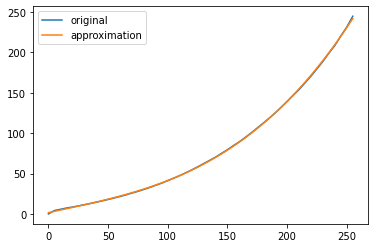

In [55]:
# Approximation
def getApproximation(x, y, n):
    apx = np.polyfit(x, y, n)
    y_apx = np.poly1d(apx)(x)
    return (x, y_apx)

channel = 1
x = range(0,256,5)
y = spdData['Luminance'][spdData['Light']==channel]
x, y_apx = getApproximation(x, y, 3)

plt.plot(x, y, label='original')
plt.plot(x, y_apx, label='approximation')
plt.legend()
plt.show()

In [93]:
pip install git+https://www.github.com/ksmet1977/luxpy -U

  Cloning https://www.github.com/ksmet1977/luxpy to c:\users\jovana\appdata\local\temp\pip-req-build-drj99r3p
  Resolved https://www.github.com/ksmet1977/luxpy to commit aa3c6ae9f05b0feaf1a6ded33a00cc85e997b435
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none -q https://www.github.com/ksmet1977/luxpy 'C:\Users\Jovana\AppData\Local\Temp\pip-req-build-drj99r3p'
You should consider upgrading via the 'C:\Users\Jovana\Desktop\Virtual\LTechnology\Scripts\python.exe -m pip install --upgrade pip' command.


[[3.6000e+02 3.6100e+02 3.6200e+02 ... 8.2800e+02 8.2900e+02 8.3000e+02]
 [4.7611e-04 9.4778e-05 2.9980e-05 ... 0.0000e+00 1.4012e-05 2.4236e-05]
 [1.2249e-04 0.0000e+00 3.3913e-04 ... 0.0000e+00 1.4301e-05 1.1742e-05]
 [4.3861e-04 7.4021e-05 0.0000e+00 ... 2.7768e-05 9.2454e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 2.6865e-06 8.9450e-06 0.0000e+00]]

Results (optim,target):
Yxy: ([42,0.30,0.24],[42,0.30,0.24])
Rf: (75.29)
Rg: (103.14)
cct(K), duv: (10341.9,-0.0402)
LER:  [[2.5120e+02]]

Flux ratios of component spectra: [[2.2519e-02 2.7788e-02 4.0490e-02 6.6334e-02]]
Driver values:  [9, 9, 21, 40]


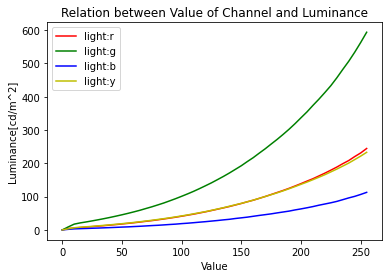

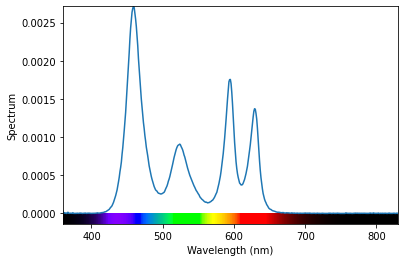

In [57]:
spdData = []
largestLum = []
interpolation_funcs = []
digit = []
primaries = []
cp = []
ct = []
w = []
obj_fcn = []
obj_tar_vals = []

spdData = load_data('./data/spectrums2.txt', spdData)
interpolation_funcs = get_luminance()
plot_luminance()

get_primaries()
cp = get_cp()
#ct = get_target_color_xyz()
ct = get_target_color_yxy('spd')
#w = three_color_mixing(cp, ct)
#w = n_color_mixing(cp, ct)
obj_fcn, obj_tar_vals = make_obj_fun('rf,rg', (90, 110))
w = do_optimization()
get_drivers()

print('Driver values: ', digit)
